# Определение возраста покупателей

## Исследовательский анализ данных

**Проект.  
Компьютерное зрение.**

**Входные данные.**
	Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя. Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

План проекта:
Провести исследовательский анализ набора фотографий.
Подготовить данные к обучению.
Обучить нейронную сеть и рассчитайте её качество.

Описание данных
Данные взяты с сайта ChaLearn Looking at People.
Они находятся в папке /datasets/faces/.

В распоряжении одна папка со всеми изображениями (/final_files) и csv-файл labels.csv с двумя колонками: file_name и real_age.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
ages = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
ages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В датасете содержится информация о возрасте 7591 человека. Пропусков нет. Типы объектов корректные.

Предоположительно, данных в датасете достаточно для обучения модели. В случае, если модель будет показывать плохие результаты, можно попробовать применить аугментацию. Но как будет указано ниже, аугментация в датасете уже произведена. Но тут возникает вопрос как была произведена выборка из общего датасета и есть ли в ней изначальные соответсвующие исходным аугментированные изображения.


In [4]:
ages.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
ages['real_age'].mode()

0    30
dtype: int64

Посмотрим на распределение данных о возрасте на графике.

<Figure size 1120x640 with 0 Axes>

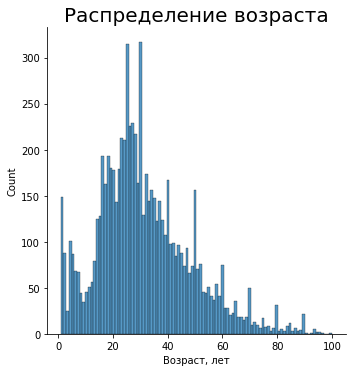

<Figure size 1440x1440 with 0 Axes>

In [6]:
plt.figure(figsize=(14,8), dpi=80)
sns.displot(ages['real_age'], bins=100)
plt.title('Распределение возраста', size=20)
plt.xlabel('Возраст, лет')
plt.figure(figsize=(20,20))
plt.show()

Распределение не гладкое, имеются пики, возраст распределен в диапазоне от 1 до 100 лет. Мода равна 30. Видно, что возраст кратный 10 в каждой возрастной категории преобладает.

 Вероятно, пики в 10-кратных цифрах связаны с особенностью разметки данных, как вариант, разметка  когда не было точной инфомации о возрасте.
 

Загрузим данные и выведем несколько изображений на экран

In [7]:
all_datagen = ImageDataGenerator(rescale=1./255)
all_n_gen_flow = all_datagen.flow_from_dataframe(
        dataframe=ages,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


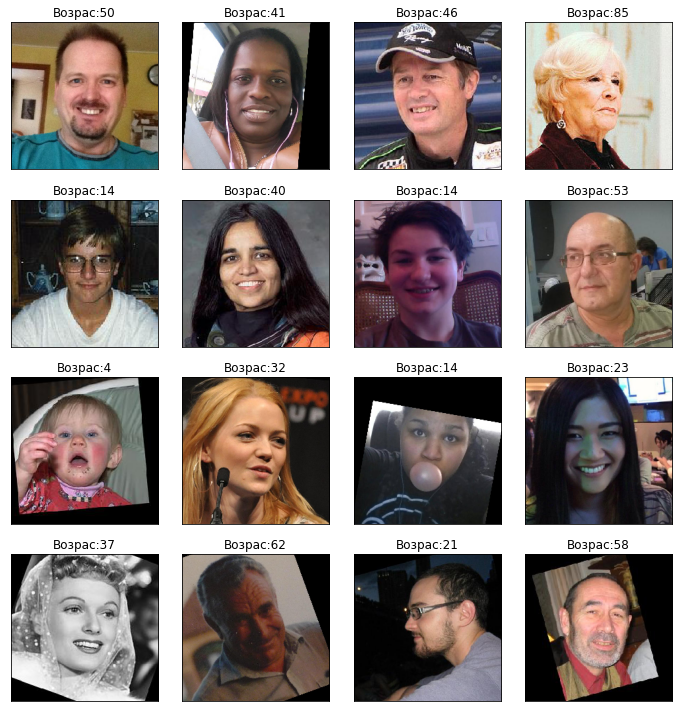

In [8]:
features, target = next(all_datagen)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Возрас:{}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


Выводы по результатам EDA:
    
- в каждой возрастной группе преобладают данные о возрасте, кратные 10. Вероятно, это связано с округлением
- наибольшее количество людей - в окрестности 30 лет
- в датасете есть помимо цветных изображений присутствуют и черно-белые
- изображения уже пред-аугментированы, как сказано на сайте датасета:
"For each image X.jpg, we also provide a corresponding X.jpg_face.jpg which contains the cropped & rotated face with a 40% margin obtained from the Mathias et. al face detector (http://markusmathias.bitbucket.org/2014_eccv_face_detection/) at multiple rotations."
То есть этап аугментации можно опустить.
- в датасете присутствуют затрудняющие прогнозирование элементы: различные "шумы" - фото в очках, пузырь от жевательной резинки и т.п, фото в профиль.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# загружаем необходимые библиотеки
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import pandas as pd
import numpy as np
#
def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
          rescale=1./255,
          validation_split=0.2
          )

    train_gen_flow = train_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='training',
          seed=12345) 

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.2
      )

    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=16,
          class_mode='raw',
          subset='validation',
          seed=12345) 

    return test_gen_flow

def create_model(input_shape):

    optimizer = Adam(lr=0.0003)

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)  

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_datagen_flow, test_data_flow, batch_size=None,
                epochs=5,  steps_per_epoch=None, validation_steps=None):
  
    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_data_flow) 

    model.fit_generator( train_datagen_flow, validation_data=test_data_flow,
      epochs=epochs, steps_per_epoch=steps_per_epoch, 
      validation_steps=validation_steps,
      verbose=2,  shuffle=True)

    return model

```

Ниже представлен фрагмент вывода  с результатами обучения модели:

```
Train for 190 steps, validate for 95 steps
Epoch 1/10
2022-08-23 13:46:24.649181: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-23 13:46:24.957280: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 52s - loss: 186.3963 - mae: 10.0260 - val_loss: 639.9669 - val_mae: 20.2343
Epoch 2/10
190/190 - 43s - loss: 79.6669 - mae: 6.7612 - val_loss: 375.2347 - val_mae: 14.3689
Epoch 3/10
190/190 - 41s - loss: 43.2948 - mae: 5.0598 - val_loss: 381.0479 - val_mae: 14.6083
Epoch 4/10
190/190 - 40s - loss: 28.7415 - mae: 4.1292 - val_loss: 127.6051 - val_mae: 8.6320
Epoch 5/10
190/190 - 41s - loss: 19.1816 - mae: 3.3963 - val_loss: 95.2378 - val_mae: 7.3275
Epoch 6/10
190/190 - 42s - loss: 14.9152 - mae: 2.9842 - val_loss: 68.9904 - val_mae: 6.4565
Epoch 7/10
190/190 - 43s - loss: 12.1168 - mae: 2.6505 - val_loss: 73.3714 - val_mae: 6.3873
Epoch 8/10
190/190 - 42s - loss: 10.0182 - mae: 2.3851 - val_loss: 65.1199 - val_mae: 6.1202
Epoch 9/10
190/190 - 39s - loss: 9.5319 - mae: 2.3295 - val_loss: 73.5423 - val_mae: 6.2604
Epoch 10/10
190/190 - 43s - loss: 8.9985 - mae: 2.2751 - val_loss: 69.8366 - val_mae: 6.3426
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 8s - loss: 69.8366 - mae: 6.3426
Test MAE: 6.3426

```

## Анализ обученной модели

Был проведен предварительный анализ данных, обучена CNN модель ResNet50. Результаты работы модели со следующими  гипер-параметрами, которые было предложено варьировать:  
`Adam(lr=0.0003), epochs=10  ` ошибка **MAE** на тестовой выборке **6.3426**. 
Это достаточный результат. То есть по сути, задачу можно считать решенной.
Возвращаясь к поставленным задачам:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя. Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

можно предположить, что для первой задачи результаты модели будут достаточны, а вот с реализацией второй следует подходить с осторожностью: учитывая среднюю ошибку в 6 лет, модель может сделать нежелательный "акцепт" на продажу алкоголя для несовершеннолетних покупателей.